In [2]:
from dap_prinz_green_jobs.getters.ojo_getters import (
    get_mixed_ojo_job_title_sample
    
)
from dap_prinz_green_jobs.getters.occupation_getters import load_job_title_soc
from dap_prinz_green_jobs import BUCKET_NAME, logger, PROJECT_DIR
from dap_prinz_green_jobs.getters.data_getters import load_s3_data, save_json_dict

import pandas as pd
import numpy as np
import altair as alt

import random
from collections import defaultdict, Counter
from tqdm import tqdm

## Import and format the data needed

In [3]:
soc_2020_data = pd.read_excel("s3://prinz-green-jobs/inputs/data/occupation_data/ons/extendedsoc2020structureanddescriptionsexcel180523.xlsx",
                         skiprows=1, sheet_name="Extended SOC Framework")

ext_rows = soc_2020_data.dropna(subset=['Sub-Unit Group'])
soc_2020_ext_dict = dict(zip(ext_rows['Sub-Unit Group'], ext_rows['Group Title']))

unit_group_rows = soc_2020_data.dropna(subset=['Unit Group'])
soc_2020_dict = dict(zip(unit_group_rows['Unit Group'], unit_group_rows['Group Title']))

green_occs_outputs = load_s3_data(
        BUCKET_NAME,
        f"outputs/data/ojo_application/extracted_green_measures/20231002/ojo_sample_occupation_green_measures_production_True_base.json",
    )
occs_measures_df = pd.DataFrame.from_dict(green_occs_outputs, orient='index').reset_index().rename(columns={'index':'id'})

for r in ['SOC_2020_EXT', 'SOC_2020', 'SOC_2010']:
    occs_measures_df[r] = occs_measures_df['SOC'].apply(lambda x: x[r] if x else None)


occs_measures_df['SOC_2020_EXT_name'] = occs_measures_df['SOC_2020_EXT'].map(soc_2020_ext_dict)
occs_measures_df['SOC_2020_name'] = occs_measures_df['SOC_2020'].apply(lambda x:soc_2020_dict.get(float(x)) if x else None)


green_inds_outputs = load_s3_data(
        BUCKET_NAME,
        f"outputs/data/ojo_application/extracted_green_measures/20231007/ojo_sample_industry_green_measures_production_True_base.json",
    )
inds_measures_df = pd.DataFrame.from_dict(green_inds_outputs, orient='index').reset_index().rename(columns={'index':'id'})

green_skills_outputs = load_s3_data(
        BUCKET_NAME,
        f"outputs/data/ojo_application/extracted_green_measures/20230914/ojo_sample_skills_green_measures_production_True_base.json",
    )

skill_measures_df = pd.DataFrame.from_dict(green_skills_outputs, orient='index').reset_index().rename(columns={'index':'id'})

# All skill matches
full_skills_outputs = load_s3_data(
        BUCKET_NAME,
        f"outputs/data/green_skill_lists/20230914/full_esco_skill_mappings.json",
    )



2023-10-10 10:08:15,653 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2023-10-10 10:08:16,706 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


## Skill information data

In [4]:
ents_explode = skill_measures_df[['id', 'ENTS']].explode("ENTS").reset_index(drop=True)
ents_explode["skill_label"] = ents_explode["ENTS"].apply(lambda x: x[0] if x else [])
ents_explode = ents_explode.explode("skill_label").reset_index(drop=True)

skill_match_thresh = 0.7
extracted_full_skill = []
extracted_full_skill_id = []
for skill_label in tqdm(ents_explode['skill_label']):
    full_skills_output = full_skills_outputs.get(skill_label)
    if full_skills_output and full_skills_output[2]>=skill_match_thresh:
        extracted_full_skill.append(full_skills_output[0])
        extracted_full_skill_id.append(full_skills_output[1])
    else:
        extracted_full_skill.append(None)
        extracted_full_skill_id.append(None)

ents_explode["extracted_full_skill"] = extracted_full_skill
ents_explode["extracted_full_skill_id"] = extracted_full_skill_id

100%|██████████████████████████████| 789324/789324 [00:00<00:00, 1028723.21it/s]


In [5]:
green_ents_explode = skill_measures_df[['id', 'GREEN_ENTS']].explode("GREEN_ENTS").reset_index(drop=True)
green_ents_explode["skill_label"] = green_ents_explode["GREEN_ENTS"].apply(lambda x: x[0] if isinstance(x, list) else None)
green_ents_explode["extracted_green_skill"] = green_ents_explode["GREEN_ENTS"].apply(
    lambda x: x[1][2][0] if isinstance(x, list) else None)
green_ents_explode["extracted_green_skill_id"] = green_ents_explode["GREEN_ENTS"].apply(
    lambda x: x[1][2][1] if isinstance(x, list) else None)

In [6]:
green_skills_df = pd.concat([ents_explode, green_ents_explode])
green_skills_df = green_skills_df[(
    (green_skills_df["skill_label"]!="") & (pd.notnull(green_skills_df["skill_label"]))
)]

# # Remove the duplicate green skills per job advert
green_skills_df.sort_values(by="extracted_green_skill", inplace=True)
green_skills_df.drop_duplicates(subset=["id", "skill_label"], keep='first', inplace=True)

green_esco_taxonomy = load_s3_data(BUCKET_NAME, "outputs/data/green_skill_lists/green_esco_data_formatted.csv")

full_esco_taxonomy = load_s3_data(
        "open-jobs-lake",
        "escoe_extension/outputs/data/skill_ner_mapping/esco_data_formatted.csv",
    )


green_order_dict = {0: 'preferredLabel', 1: 'altLabels'}
green_esco_taxonomy["type_sort"] = green_esco_taxonomy['type'].map(green_order_dict)
green_esco_taxonomy.sort_values(by="type_sort", inplace=True, ascending=False)
green_esco_taxonomy.drop_duplicates(subset=["id"], keep='first', inplace=True)
green_skill_id_2_name = dict(zip(green_esco_taxonomy['id'], green_esco_taxonomy['description']))

full_order_dict = {0: 'preferredLabel', 1: 'altLabels', 2: 'level_2', 3: 'level_3'}
full_esco_taxonomy["type_sort"] = full_esco_taxonomy['type'].map(green_order_dict)
full_esco_taxonomy.sort_values(by="type_sort", inplace=True, ascending=False)
full_esco_taxonomy.drop_duplicates(subset=["id"], keep='first', inplace=True)
full_skill_id_2_name = dict(zip(full_esco_taxonomy['id'], full_esco_taxonomy['description']))


green_skills_df['full_skill_preferred_name'] = green_skills_df['extracted_full_skill_id'].map(full_skill_id_2_name)
green_skills_df['green_skill_preferred_name'] = green_skills_df['extracted_green_skill_id'].map(green_skill_id_2_name)

## Get the green topics per SOC 2010

In [7]:
from dap_prinz_green_jobs.pipeline.green_measures.occupations.occupations_measures_utils import OccupationMeasures

om = OccupationMeasures()
om.load()

2023-10-10 10:08:46,975 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-10-10 10:08:47,349 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device: cpu
2023-10-10 10:08:57,001 - dap_prinz_green_jobs - INFO - Loading SOC job title embeddings
2023-10-10 10:09:11,612 - dap_prinz_green_jobs - INFO - Predict UK SOC for the occupations in the ONET green topics data
2023-10-10 10:09:11,615 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2023-10-10 10:09:11,890 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device: cpu
2023-10-10 10:09:16,421 - dap_prinz_green_jobs - INFO - Loading SOC job title embeddings
2023-10-10 10:09:17,712 - dap_prinz_green_jobs - INFO - Embedding texts in 2.708 batches


0it [00:00, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

1it [00:02,  2.87s/it]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2it [00:05,  2.87s/it]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

3it [00:07,  2.60s/it]

2023-10-10 10:09:25,505 - dap_prinz_green_jobs - INFO - Finding most similar job titles for 1354 job titles



1354it [00:00, 13000.47it/s]

2023-10-10 10:09:25,660 - dap_prinz_green_jobs - INFO - Finding most likely SOC
2023-10-10 10:09:25,663 - dap_prinz_green_jobs - INFO - Found SOCs for 79.83751846381094% of the job titles


## Get SIC 2 digit name

In [8]:
from dap_prinz_green_jobs.getters.industry_getters import load_sic

In [9]:
sic_data = load_sic()

In [10]:
sic_names = dict(zip(sic_data['Division'].tolist(), sic_data['Description'].tolist()))

## Combine it all

In [11]:
print(len(occs_measures_df))
occs_measures_enhanced = occs_measures_df[pd.notnull(occs_measures_df['SOC_2020_EXT_name'])]
occs_measures_enhanced = occs_measures_enhanced.merge(skill_measures_df, on='id')
occs_measures_enhanced = occs_measures_enhanced.merge(inds_measures_df, on='id')
occs_measures_enhanced.loc[occs_measures_enhanced['INDUSTRY GHG PER UNIT EMISSIONS']==':', 'INDUSTRY GHG PER UNIT EMISSIONS'] = None # A curio for 3 rows

occs_measures_enhanced['SIC_2_digit'] = occs_measures_enhanced['SIC'].apply(lambda x: str(x)[0:2] if x else None)
occs_measures_enhanced['SIC_2_digit_name'] = occs_measures_enhanced['SIC_2_digit'].apply(lambda x: sic_names.get(x) if x else None)

occs_measures_enhanced['green_topics_lists'] = occs_measures_enhanced['SOC_2010'].apply(lambda x: om.soc_green_measures_dict.get(x)['ONET_green_topics'])

39866


In [12]:
print(occs_measures_enhanced['SIC'].nunique())
print(occs_measures_enhanced['SIC_2_digit'].nunique())
print(occs_measures_enhanced['SIC_2_digit_name'].nunique())

749
101
87


## Create aggregated dict

In [13]:
occ_unique = occs_measures_enhanced.drop_duplicates(subset=['GREEN CATEGORY', 'GREEN/NOT GREEN', 'GREEN TIMESHARE',
       'GREEN TOPICS', 'SOC_2020_EXT', 'SOC_2020', 'SOC_2010',
       'SOC_2020_EXT_name', 'SOC_2020_name'])
print(len(occ_unique))
print(occs_measures_enhanced['SOC_2020_EXT'].nunique())

882
799


In [22]:
occ_aggregated_data = {}
for SOC_2020_ext in tqdm(occs_measures_enhanced['SOC_2020_EXT'].unique()): 
    if pd.notnull(SOC_2020_ext):
        occ_filtered_data = occs_measures_enhanced[occs_measures_enhanced['SOC_2020_EXT']==SOC_2020_ext]
        
        occ_filtered_skills = green_skills_df[green_skills_df['id'].isin(set(occ_filtered_data['id'].tolist()))]

        top_green_skill_num = occ_filtered_skills[['green_skill_preferred_name', 'extracted_green_skill_id']].value_counts()[0:5].to_dict()
        top_green_skill_prop = occ_filtered_skills[['green_skill_preferred_name', 'extracted_green_skill_id']].value_counts(normalize=True)[0:5].to_dict()

        green_skill_info = []
        for k,v in top_green_skill_num.items():
            green_skill_info.append(
                {"skill_name": k[0], "skill_id": k[1], "num_job_ads": v, "prop_job_ads": top_green_skill_prop[k]})
        
        top_5_not_green_skills_num = occ_filtered_skills[pd.isnull(occ_filtered_skills['extracted_green_skill'])][['full_skill_preferred_name', 'extracted_full_skill_id']].value_counts()[0:5].to_dict()
        top_5_not_green_skills_prop =  occ_filtered_skills[pd.isnull(occ_filtered_skills['extracted_green_skill'])][['full_skill_preferred_name', 'extracted_full_skill_id']].value_counts(normalize=True)[0:5].to_dict()

        not_green_skill_info = []
        for k,v in top_5_not_green_skills_num.items():
            not_green_skill_info.append(
                {"skill_name": k[0], "skill_id": k[1], "num_job_ads": v, "prop_job_ads": top_5_not_green_skills_prop[k]})

        top_5_sics_num = occ_filtered_data[['SIC_2_digit', 'SIC_2_digit_name']].value_counts()[0:5].to_dict()
        top_5_sics_prop = occ_filtered_data[['SIC_2_digit', 'SIC_2_digit_name']].value_counts(normalize=True)[0:5].to_dict()

        top_5_sics = []
        for k,v in top_5_sics_num.items():
            top_5_sics.append({"sic_id": k[0], "sic_name": k[1], "num_job_ads": v, "prop_job_ads": top_5_sics_prop[k]})
        
        occ_aggregated_data[SOC_2020_ext] = {
            # General
            'num_job_ads': len(occ_filtered_data),
            'prop_job_ads': len(occ_filtered_data)/len(occs_measures_enhanced),
            'SOC_2020_EXT': SOC_2020_ext,
            'SOC_2020_EXT_name': occ_filtered_data['SOC_2020_EXT_name'].mode()[0] if len(occ_filtered_data['SOC_2020_EXT_name'].mode())!=0 else None,
            'SOC_2020': occ_filtered_data['SOC_2020'].mode()[0] if len(occ_filtered_data['SOC_2020'].mode())!=0 else None,
            'SOC_2010': occ_filtered_data['SOC_2010'].mode()[0] if len(occ_filtered_data['SOC_2010'].mode())!=0 else None,
            # Occupations
            # 'occ_green_category': occ_filtered_data['GREEN CATEGORY'].mode()[0] if len(occ_filtered_data['GREEN CATEGORY'].mode())!=0 else None,
            # 'occ_green_binary': occ_filtered_data['GREEN/NOT GREEN'].mode()[0] if len(occ_filtered_data['GREEN/NOT GREEN'].mode())!=0 else None,
            'occ_timeshare': occ_filtered_data['GREEN TIMESHARE'].mode()[0] if len(occ_filtered_data['GREEN TIMESHARE'].mode())!=0 else None,
            'occ_topics': occ_filtered_data['GREEN TOPICS'].mode()[0] if len(occ_filtered_data['GREEN TOPICS'].mode())!=0 else None,
            'green_topics_lists': occ_filtered_data['green_topics_lists'].iloc[0],
            # Skills
            'average_num_skills': occ_filtered_data['NUM_SPLIT_ENTS'].mean(),
            # 'var_num_skills': occ_filtered_data['NUM_SPLIT_ENTS'].var(skipna=True),
            # 'prop_ads_lt_5_skills': sum(occ_filtered_data['NUM_SPLIT_ENTS']<5)/len(occ_filtered_data),
            'average_prop_green_skills': occ_filtered_data['PROP_GREEN'].mean(),
            # 'var_prop_green_skills': occ_filtered_data['PROP_GREEN'].var(skipna=True),
            'top_5_green_skills': green_skill_info,
            'top_5_not_green_skills': not_green_skill_info,
            # Industry
            'num_unique_SIC2': occ_filtered_data["SIC_2_digit"].nunique(),
            'num_null_sic2': len(occ_filtered_data[pd.isnull(occ_filtered_data["SIC_2_digit"])]),
            'num_top_sic2': occ_filtered_data['SIC_2_digit'].value_counts()[0] if len(occ_filtered_data['SIC_2_digit'].value_counts())>0 else None,
            'num_other_sic2': sum(occ_filtered_data['SIC_2_digit'].value_counts()[1:]) if len(occ_filtered_data['SIC_2_digit'].value_counts())>1 else None,
            'average_ind_perunit_ghg': occ_filtered_data['INDUSTRY GHG PER UNIT EMISSIONS'].mean(),
            'average_ind_prop_hours': occ_filtered_data['INDUSTRY PROP HOURS GREEN TASKS'].mean(),
            'average_ind_prop_workers': occ_filtered_data['INDUSTRY PROP WORKERS GREEN TASKS'].mean(),
            'top_5_sics': top_5_sics,
        }

100%|█████████████████████████████████████████| 799/799 [00:27<00:00, 28.62it/s]


## Pull out some examples

In [23]:
len(occ_aggregated_data)

799

In [24]:
occ_aggregated_df = pd.DataFrame(occ_aggregated_data).T
occ_aggregated_df = occ_aggregated_df.reset_index()
occ_aggregated_df.rename(columns={'index': 'SOC_2020_EXT'}, inplace=True)
occ_aggregated_df.head(2)

,SOC_2020_EXT,num_job_ads,prop_job_ads,SOC_2020_EXT,SOC_2020_EXT_name,SOC_2020,SOC_2010,occ_timeshare,occ_topics,green_topics_lists,...,top_5_green_skills,top_5_not_green_skills,num_unique_SIC2,num_null_sic2,num_top_sic2,num_other_sic2,average_ind_perunit_ghg,average_ind_prop_hours,average_ind_prop_workers,top_5_sics
0,2151/02,39,0.001322,2151/02,Ecologists,2151,2141,57.1,46,"[Wildlife, Energy engineering, Green research,...",...,"[{'skill_name': 'conduct ecological surveys', ...","[{'skill_name': 'write work-related reports', ...",19,11,6,22,0.305769,10.761538,55.957692,"[{'sic_id': '64', 'sic_name': 'Other financial..."
1,4143/99,83,0.002814,4143/99,Customer service managers n.e.c.,4143,7220,0.0,1,[Infrastructure],...,"[{'skill_name': 'promote sustainability', 'ski...","[{'skill_name': 'communication', 'skill_id': '...",32,14,11,58,0.337576,9.802941,47.904412,"[{'sic_id': '64', 'sic_name': 'Other financial..."


## Add where this occupation sits
Get IQR boundaries for each green measure and set categorical values for each of them.

In [25]:
big_enough_data = occ_aggregated_df[occ_aggregated_df['num_job_ads']>25]

In [26]:
def categorical_assign(value, all_values, rev=False):

    q1 = all_values.quantile(.33)
    q2 = all_values.quantile(.66)

    if pd.notnull(value):
        if value <= q1:
            if rev:
                return "high"
            else:
                return "low"
        elif value <= q2:
            return "mid"
        else:
            if rev:
                return "low"
            else:
                return "high"
    else:
        return None

In [27]:
big_enough_data['occ_greenness'] = big_enough_data['occ_timeshare'].apply(lambda x: categorical_assign(x, big_enough_data['occ_timeshare']))
big_enough_data['ind_greenness'] = big_enough_data['average_ind_perunit_ghg'].apply(
    lambda x: categorical_assign(x, big_enough_data['average_ind_perunit_ghg'], rev=True))
big_enough_data['skills_greenness'] = big_enough_data['average_prop_green_skills'].apply(lambda x: categorical_assign(x, big_enough_data['average_prop_green_skills']))

/var/folders/xc/s255_bsx0l7cbx43t290kjtr0000gn/T/ipykernel_33468/543948785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_enough_data['occ_greenness'] = big_enough_data['occ_timeshare'].apply(lambda x: categorical_assign(x, big_enough_data['occ_timeshare']))
/var/folders/xc/s255_bsx0l7cbx43t290kjtr0000gn/T/ipykernel_33468/543948785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_enough_data['ind_greenness'] = big_enough_data['average_ind_perunit_ghg'].apply(
/var/folders/xc/s255_bsx0l7cbx43

In [29]:
def get_one_score(occ,ind,skill):

    score_dict = {"high":2, "mid":1, "low":0}
    
    if occ in score_dict:
        score = score_dict[occ]+ score_dict[ind] + score_dict[skill]
        # return score

        if score <= 1:
            # 0,1
            return "low"
        elif score <=3:
            # 2,3 
            return "low-mid"
        elif score <=5:
            # 4,5
            return "mid-high"
        else:
            # 6
            return "high"
    else:
        return None



In [30]:
big_enough_data["greenness_score"] = big_enough_data.apply(lambda x: get_one_score(x['occ_greenness'], x['ind_greenness'], x['skills_greenness']), axis = 1)

/var/folders/xc/s255_bsx0l7cbx43t290kjtr0000gn/T/ipykernel_33468/1239927552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_enough_data["greenness_score"] = big_enough_data.apply(lambda x: get_one_score(x['occ_greenness'], x['ind_greenness'], x['skills_greenness']), axis = 1)


In [31]:
big_enough_data["greenness_score"].value_counts()

low-mid     86
mid-high    76
low         46
high        10
Name: greenness_score, dtype: int64

In [32]:
big_enough_data.columns

Index(['SOC_2020_EXT', 'num_job_ads', 'prop_job_ads', 'SOC_2020_EXT',
       'SOC_2020_EXT_name', 'SOC_2020', 'SOC_2010', 'occ_timeshare',
       'occ_topics', 'green_topics_lists', 'average_num_skills',
       'average_prop_green_skills', 'top_5_green_skills',
       'top_5_not_green_skills', 'num_unique_SIC2', 'num_null_sic2',
       'num_top_sic2', 'num_other_sic2', 'average_ind_perunit_ghg',
       'average_ind_prop_hours', 'average_ind_prop_workers', 'top_5_sics',
       'occ_greenness', 'ind_greenness', 'skills_greenness',
       'greenness_score'],
      dtype='object')

## Save

In [33]:
big_enough_data.to_csv("occupation_aggregated_data_new.csv")

## Look into

In [34]:
greenness_types = ["low", "low-mid", "mid-high", "high"]
for greenness_type in greenness_types:
    print(f"Greenness type {greenness_type} :")
    print(big_enough_data[big_enough_data["greenness_score"]==greenness_type].sort_values(by = 'num_job_ads', ascending=False)['SOC_2020_EXT_name'].tolist()[0:5])

Greenness type low :
['Software developers', 'Market researchers (excludes interviewers)', 'Student ambassadors', 'Bookkeepers, payroll managers and wage clerks n.e.c.', 'Recruitment consultants']
Greenness type low-mid :
['Marketing managers', 'Business sales executives', 'Financial accounts managers n.e.c.', 'Electrical engineers n.e.c.', 'Compliance and regulatory professionals']
Greenness type mid-high :
['Sustainability officers', 'Business and financial project management professionals n.e.c.', 'Business development managers', 'Production managers and directors in manufacturing', 'Procurement and purchasing managers and directors']
Greenness type high :
['Landlords, property and housing managers ', 'Energy advisers and assessors', 'Road traffic and transport safety officers', 'Plumbers and heating and ventilation installers and repairers', 'Town planning officers']


## Quantiles

In [38]:
big_enough_data['occ_timeshare'].quantile(.33)

0.0

In [39]:
big_enough_data['occ_timeshare'].quantile(.66)

16.166

<Axes: >

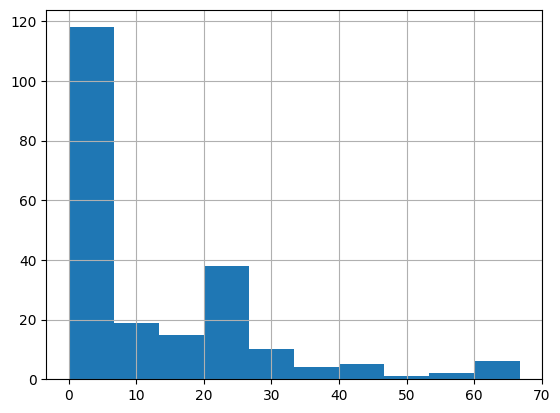

In [40]:
big_enough_data['occ_timeshare'].hist()

- Occupation:
- When the values for the % time spent on green tasks per occupation are split equally into thirds, this occupations' value sits in the lowest third.
- When the values for the % time spent on green tasks per occupation are split equally into thirds, this occupations' value sits in the mid third.
- When the values for the % time spent on green tasks per occupation are split equally into thirds, this occupations' value sits in the highest third.

- Industry:
- When the values for the average per unit GHG emissions for industries this occupation sit in are split equally into thirds, this occupations' value sits in the lowest third.
- When the values for the average per unit GHG emissions for industries this occupation sit in are split equally into thirds, this occupations' value sits in the mid third.
- When the values for the average per unit GHG emissions for industries this occupation sit in are split equally into thirds, this occupations' value sits in the highest third.

- Skills:
- When the values for the average proportion of green skills per occupation are split equally into thirds, this occupations' value sits in the lowest third.
- When the values for the average proportion of green skills per occupation are split equally into thirds, this occupations' value sits in the mid third.
- When the values for the average proportion of green skills per occupation are split equally into thirds, this occupations' value sits in the highest third.

In [47]:
big_enough_data['occ_greenness'].value_counts()

low     92
high    74
mid     52
Name: occ_greenness, dtype: int64

In [43]:
big_enough_data[big_enough_data['occ_greenness']=='low']['occ_timeshare'].value_counts()

0.0    92
Name: occ_timeshare, dtype: int64

In [45]:
big_enough_data[big_enough_data['occ_greenness']=='mid']['occ_timeshare'].value_counts()

3.8     5
16.1    4
3.0     3
9.8     3
6.1     3
2.1     2
0.1     2
10.3    2
7.7     2
0.6     2
3.9     1
8.5     1
0.5     1
7.0     1
2.7     1
13.6    1
13.1    1
0.8     1
6.4     1
11.8    1
9.1     1
3.3     1
12.5    1
13.2    1
7.1     1
1.4     1
12.2    1
10.0    1
14.7    1
0.9     1
6.3     1
15.2    1
10.8    1
6.9     1
Name: occ_timeshare, dtype: int64

In [46]:
big_enough_data[big_enough_data['occ_greenness']=='high']['occ_timeshare'].value_counts()

22.4    10
20.8     7
62.5     5
18.8     4
33.3     3
22.5     3
32.5     3
25.3     3
21.1     3
22.6     3
25.1     2
45.3     2
20.0     2
42.1     2
39.0     2
26.2     2
57.1     2
23.1     2
23.4     2
28.9     1
18.5     1
22.1     1
35.6     1
16.4     1
28.6     1
32.1     1
33.8     1
28.8     1
42.9     1
66.7     1
50.0     1
Name: occ_timeshare, dtype: int64